In [49]:
import re
import collections
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from tqdm import tqdm
import nltk

from collections import Counter

In [50]:
df = pd.read_csv('../datasets/raw/2020_06_23_CE-BVerwG_DE_Datensatz.csv')

In [51]:
kuerzel = pd.read_csv('../src/data/gesetzbuch_abbreviations.csv')['abbreviation'].tolist()

In [115]:
minidf = df.sample(frac = 0.05)
minidf['text_normalized'] = minidf['text'].str.replace("\n", " ")\
    .replace("(" + "|".join(kuerzel) + ")", "<gesetzbuch>", regex=True).str.lower()\
    .replace('\s+', ' ', regex=True)\
    .replace("[0-9]+", "<number>", regex=True)\
    .replace("(januar|februar|märz|april|mai|juni|juli|august|september|oktober|november|dezember)", "<monat>", regex=True)\
    .replace("<number>. <monat> <number>", "<datum>")
    
#.replace("§[ ]{<number>}+ [abs.[ ]{<number>}+] vwgo")

In [116]:
vocab = nltk.lm.Vocabulary(minidf['text_normalized'], unk_cutoff=10)
data = []
for judgement in minidf['text_normalized']:
    data.extend(judgement.split(" "))
filtered_data = [word for word in data if len(word) > 1 or not word.isalpha()]
print(filtered_data[:10])

['bundesverwaltungsgericht', 'im', 'namen', 'des', 'volkes', 'urteil', 'bverwg', '<number>', '<number>.<number>', 'ovg']


In [117]:

len(minidf)

1211

In [118]:
def compute_top_phrase_frequencies(min_len, max_len=None, top_n=4):
    if not max_len:
        max_len = min_len
    longgrams = list(nltk.everygrams(filtered_data, min_len, max_len))
    most_common = Counter(longgrams)
    most_common = most_common.most_common(1000)
    return most_common


def filter_duplicate_phrases(most_common, top_n=10):
         
    phrases = []
    frequencies = []
    lengths = []

    for length in list(most_common.keys())[::-1]:  # iterate over ngrams of length 'length'
        counter = 0
        previous_frequencies = []
        # removes duplices from phrases list
        for phrase, frequency in most_common[length]:
            phrase_candidate = " ".join(phrase)

            # only add to list of patterns if phrase is new or if 
            # it is a substring of an existing pattern but occurs more frequently
            unseen_pattern = True
            for i in range(len(phrases)):
                if phrase_candidate in phrases[i] and frequency <= frequencies[i]:
                    unseen_pattern = False
                    break

            if unseen_pattern and frequency not in previous_frequencies:
                phrases.append(phrase_candidate)
                lengths.append(length)
                
                frequencies.append(frequency)
                counter += 1
                if counter > top_n:
                    break
                

    return phrases, frequencies, lengths


In [119]:
minlen = 4
maxlen = 100
common_phrases = {}
for i in tqdm(range(minlen, maxlen)):
    common_phrases[i] = compute_top_phrase_frequencies(i)


100%|██████████| 96/96 [04:46<00:00,  2.98s/it]


In [131]:
common_phrases_selection = [list(common_phrases.keys())[:20]
phrases, frequencies, lengths = filter_duplicate_phrases(common_phrases)

TypeError: unhashable type: 'slice'

In [132]:
for i in range(len(phrases)):
    print("freq: ", frequencies[i], "length", lengths[i])
    print(phrases[i])
    print("")

freq:  67 length 99
- <number> - - <number> - - <number> - - <number> - - <number> - - <number> - - <number> - - <number> - - <number> - - <number> - - <number> - - <number> - - <number> - - <number> - - <number> - - <number> - - <number> - - <number> - - <number> - - <number> - - <number> - - <number> - - <number> - - <number> - - <number> - - <number> - - <number> - - <number> - - <number> - - <number> - - <number> - - <number> - - <number> -

freq:  66 length 99
<number> - - <number> - - <number> - - <number> - - <number> - - <number> - - <number> - - <number> - - <number> - - <number> - - <number> - - <number> - - <number> - - <number> - - <number> - - <number> - - <number> - - <number> - - <number> - - <number> - - <number> - - <number> - - <number> - - <number> - - <number> - - <number> - - <number> - - <number> - - <number> - - <number> - - <number> - - <number> - - <number> - -

freq:  66 length 99
- - <number> - - <number> - - <number> - - <number> - - <number> - - <number> - 

nach den vorschriften des bürgerlichen rechts den von ihr anhängig gemachten rechtsbehelf ohne einwilligung des betreuers einlegen könnte, sind nicht erfüllt. zwar bedarf der betreute nach § <number> abs. <number> satz <number> <gesetzbuch> trotz eines angeordneten einwilligungsvorbehalts nicht der einwilligung des betreuers, wenn die willenserklärung dem betreuten lediglich einen rechtlichen vorteil bringt.

freq:  4 length 52
beschwerde gegen die nichtzulassung der revision in dem urteil des oberverwaltungsgerichts für das land nordrhein-westfalen vom <number>. <monat> <number> mit schriftsatz vom <number>. <monat> <number> zurückgenommen. das beschwerdeverfahren ist deshalb in entsprechender anwendung von § <number> satz <number>, § <number> abs. <number> satz <number>, § <number> abs. <number> satz <number> <gesetzbuch> einzustellen.

freq:  4 length 52
verfahren vor dem bundesverwaltungsgericht ist abzulehnen, weil die beabsichtigte rechtsverfolgung aus dem oben genannten grund ke

<ipython-input-130-068ba2d59633>:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


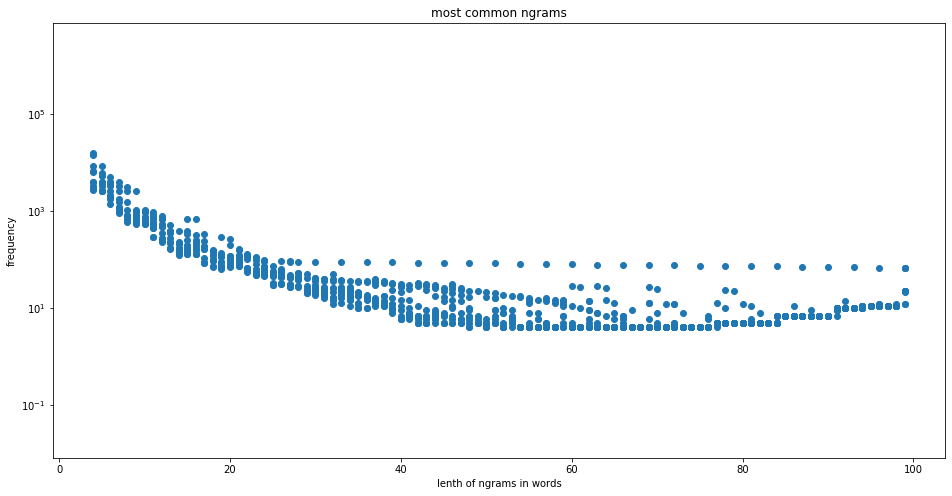

In [130]:
fig = plt.figure(figsize =(16,8))
plt.title("most common ngrams")

plt.ylabel("frequency")
plt.yscale("log")
plt.xlabel("lenth of ngrams in words")
plt.scatter(lengths, frequencies)
fig.show()

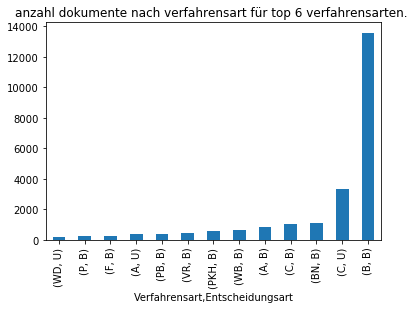

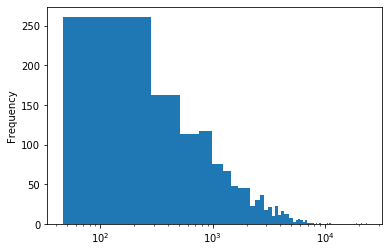

In [82]:
plt.title("anzahl dokumente nach verfahrensart für top 6 verfahrensarten. ")
subset = df.groupby(['Verfahrensart', 'Entscheidungsart']).size()
subset[subset > 200].sort_values().plot(kind='bar')
plt.show()
count = minidf['text'].str.split(" ").apply(len).sort_values()
plt.xscale("log")
count.plot.hist(bins=100)
plt.show()

In [11]:
import spacy #load spacy
nlp = spacy.load("de_core_news_sm", disable=['parser', 'tagger', 'ner'])
#stopwords = stopwords.words("german")

def normalize(comment, lowercase, remove_stopwords):
    if lowercase:
        comment = comment.lower()
    comment = nlp(comment)
    lemmatized = list()
    for word in comment:
        lemma = word.lemma_.strip()
        if lemma:
            if not remove_stopwords or (remove_stopwords and lemma not in stops):
                lemmatized.append(lemma)
    return " ".join(lemmatized)


In [29]:
import pyspark
from pyspark.sql import SparkSession, Row
from pyspark.sql.types import StructType,StructField, StringType

spark = SparkSession.builder.appName('SparkByExamples.com').getOrCreate()


In [31]:
from pyspark.ml.fpm import PrefixSpan
from pyspark import SparkContext

sc = SparkContext.getOrCreate();
plist = minidf['text_normalized'].tolist()
rdd = sc.parallelize(plist)
#df = spark.createDataFrame(rdd)

In [32]:
prefixSpan = PrefixSpan(minSupport=0.5, maxPatternLength=20,
                        maxLocalProjDBSize=3200000)

# Find frequent sequential patterns.
prefixSpan.findFrequentSequentialPatterns(rdd).show()

AttributeError: 'RDD' object has no attribute '_jdf'

In [35]:
from pyspark.ml.fpm import PrefixSpan

df = sc.parallelize([Row(sequence=[[1, 2], [3]]),
                     Row(sequence=[[1], [3, 2], [1, 2]]),
                     Row(sequence=[[1, 2], [5]]),
                     Row(sequence=[[6]])]).toDF()

prefixSpan = PrefixSpan(minSupport=0.5, maxPatternLength=5)

# Find frequent sequential patterns.
prefixSpan.findFrequentSequentialPatterns(df).show()

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.runJob.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 3.0 failed 1 times, most recent failure: Lost task 0.0 in stage 3.0 (TID 3, 192.168.2.122, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/home/zastrow-marcks/.local/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 477, in main
    ("%d.%d" % sys.version_info[:2], version))
Exception: Python in worker has different version 2.7 than that in driver 3.8, PySpark cannot run with different minor versions. Please check environment variables PYSPARK_PYTHON and PYSPARK_DRIVER_PYTHON are correctly set.

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:503)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:638)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:621)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:456)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:941)
	at scala.collection.Iterator.foreach$(Iterator.scala:941)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:315)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:313)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:307)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:307)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:294)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:288)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.api.python.PythonRDD$.$anonfun$runJob$1(PythonRDD.scala:154)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2139)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:127)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:446)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1377)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:449)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:834)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2059)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2008)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2007)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2007)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:973)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:973)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:973)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2239)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2188)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2177)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:775)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2099)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2120)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2139)
	at org.apache.spark.api.python.PythonRDD$.runJob(PythonRDD.scala:154)
	at org.apache.spark.api.python.PythonRDD.runJob(PythonRDD.scala)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.base/java.lang.Thread.run(Thread.java:834)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/home/zastrow-marcks/.local/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 477, in main
    ("%d.%d" % sys.version_info[:2], version))
Exception: Python in worker has different version 2.7 than that in driver 3.8, PySpark cannot run with different minor versions. Please check environment variables PYSPARK_PYTHON and PYSPARK_DRIVER_PYTHON are correctly set.

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:503)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:638)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:621)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:456)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:941)
	at scala.collection.Iterator.foreach$(Iterator.scala:941)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:315)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:313)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:307)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:307)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:294)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:288)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.api.python.PythonRDD$.$anonfun$runJob$1(PythonRDD.scala:154)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2139)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:127)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:446)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1377)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:449)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more
